# Preliminaries

Install the nflreader R package, which we'll use to download game score data.

In [46]:
install.packages("nflreadr")                                                                      #

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Part 1: Estimating the optimal $\alpha$ for the Pythagorean formula

We start with a dataset of game scores, and we want to caculate winning percentage and Pythagorean winning percentage for each team. We'll start by assuming the Pythagorean exponent $\alpha$ is 2, but then we'll work out the optimal value for $\alpha$.

In [47]:
data <- nflreadr::load_schedules(seasons = 2021:2023) |>                                          #
  dplyr::filter(game_type == "REG")   # filter to regular season games                            #

Because of how our data are structured (one row per game with one team identified as the home team, the other as the away team), we will perform two separate aggregations, and then we will combine those aggregations into one.

The first aggregation calculates each team's record, points scored and points allowed, in home gamesn. The second aggregation calculates each team's record, points scored and points allowed, in away gamest. Then we combine the two separate aggregations.

In [48]:
# Calculate each team's home record                                                               #
record_home <- data |>                                                                            #
  dplyr::group_by(season, team = home_team) |>                                                    #
  dplyr::summarize(                                                                               #
    wins = sum(home_score > away_score),                                                          #
    losses = sum(home_score < away_score),                                                        #
    ties = sum(home_score == away_score),                                                         #
    points_scored = sum(home_score),                                                              #
    points_allowed = sum(away_score),                                                             #
    .groups = "drop"                                                                              #
  )                                                                                               #

# Calculate each team's away record                                                               #
record_away <- data |>                                                                            #
  dplyr::group_by(season, team = away_team) |>                                                    #
  dplyr::summarize(                                                                               #
    wins = sum(away_score > home_score),                                                          #
    losses = sum(away_score < home_score),                                                        #
    ties = sum(away_score == home_score),                                                         #
    points_scored = sum(away_score),                                                              #
    points_allowed = sum(home_score),                                                             #
    .groups = "drop"                                                                              #
  )                                                                                               #

# Calculate each team's record (combining their wins and their losses)                            #
record <- dplyr::bind_rows(record_home, record_away) |>                                           #
  dplyr::group_by(season, team) |>                                                                #
  dplyr::summarize(                                                                               #
    wins = sum(wins),                                                                             #
    losses = sum(losses),                                                                         #
    ties = sum(ties),                                                                             #
    points_scored = sum(points_scored),                                                           #
    points_allowed = sum(points_allowed),                                                         #
    .groups = "drop"                                                                              #
  )                                                                                               #

head(record)                                                                                      #

season,team,wins,losses,ties,points_scored,points_allowed
<int>,<chr>,<int>,<int>,<int>,<int>,<int>
2021,ARI,11,6,0,449,366
2021,ATL,7,10,0,313,459
2021,BAL,8,9,0,387,392
2021,BUF,11,6,0,483,289
2021,CAR,5,12,0,304,404
2021,CHI,6,11,0,311,407


EXERCISE #0

Calculate each team's Pythagorean winning percentage in each season, assuming the Pythagorean exponent $\alpha$ is 2. What are the strongest team-seasons by Pythagorean winning percentage?

In [49]:
alpha <- 2                                                                                        #

win_pct <- record |>                                                                              #
  dplyr::mutate(                                                                                  #
    games = wins + losses,  # exclude ties from record calculation                                #
    actual_win_pct = wins / games,                                                                #
    pythag_win_pct = points_scored^alpha / (points_scored^alpha + points_allowed^alpha)           #
  ) |>                                                                                            #
  dplyr::select(season, team, games, wins, losses, actual_win_pct, pythag_win_pct)                #

win_pct |>                                                                                        #
  dplyr::arrange(-pythag_win_pct) |>                                                              #
  head()                                                                                          #

season,team,games,wins,losses,actual_win_pct,pythag_win_pct
<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
2023,BAL,17,13,4,0.7647059,0.7484672
2021,BUF,17,11,6,0.6470588,0.7363688
2023,SF,17,12,5,0.7058824,0.7308032
2022,SF,17,13,4,0.7647059,0.7252112
2023,DAL,17,12,5,0.7058824,0.7230719
2022,BUF,16,13,3,0.8125000,0.7167934


EXERCISE #1

Plot Pythagorean winning percentage (x-axis) vs. observed winning percentage (y-axis), and calculate the error: Across all team-seasons, what is the average squared difference between actual winning percentage and Pythagorean winning percentage?

error
<dbl>
0.007136893


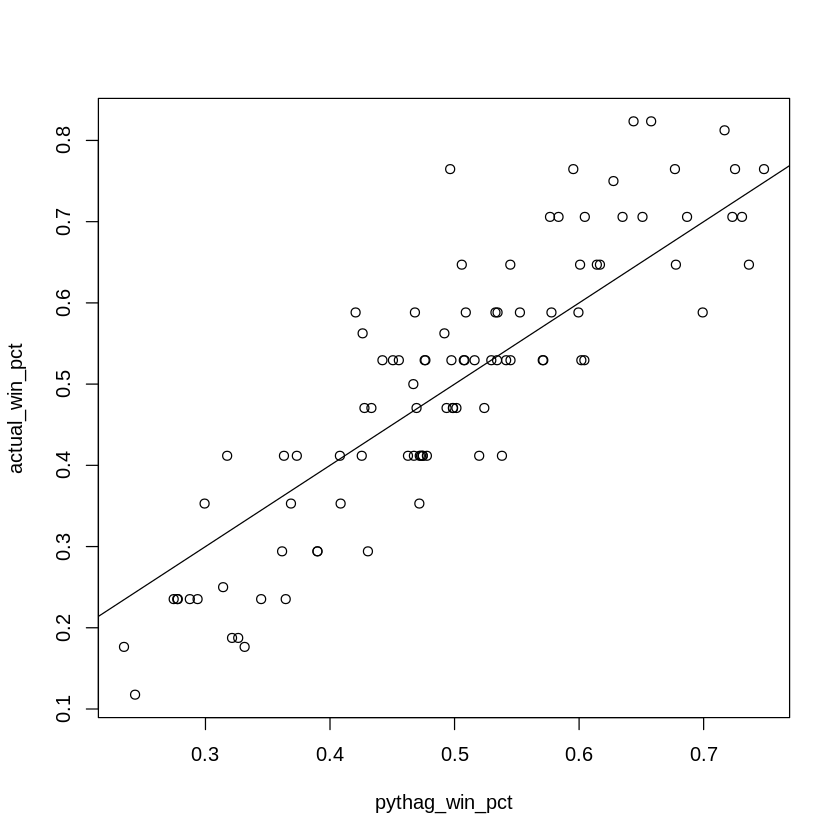

In [50]:
win_pct |>                                                                                        #
  with(plot(x = pythag_win_pct, y = actual_win_pct))                                              #
abline(0, 1)                                                                                      #

win_pct |>                                                                                        #
  dplyr::summarize(error = mean((actual_win_pct - pythag_win_pct)^2))                             #

EXERCISE #2

Create a function that takes in (1) a dataframe of games and (2) a value for the Pythagorean exponent alpha, and returns the actual winning percentage, Pythag winning percentage, and residual winning percentage for each team-season.

In [51]:
calculate_win_pct <- function(record, alpha) {                                                    #

  win_pct <- record |>                                                                            #
    dplyr::mutate(                                                                                #
      games = wins + losses,                                                                      #
      actual_win_pct = wins / games,                                                              #
      pythag_win_pct = points_scored^alpha / (points_scored^alpha + points_allowed^alpha)         #
    ) |>                                                                                          #
    dplyr::select(team, games, wins, losses, actual_win_pct, pythag_win_pct)                      #

  return(win_pct)                                                                                 #
}                                                                                                 #

EXERCISE #3

Create a vector of different possible values of $\alpha$, ranging from 0 to 10, with increments of 0.1 (so the sequence is 0.0, 0.1, 0.2, ..., 9.9, 10.0). Use a for loop to loop over every possible value of $\alpha$, and calculate the error corresponding to that value of $\alpha$. Which value of $\alpha$ leads to the smallest error?

To see a hint, double click **here**.
<!---
You will have to create a vector to hold the errors that you calculate. There are a total of 101 errors that you will calculate, so you can create this vector using `error <- rep(NA, length = 101)`. Then, at each step in the for loop, insert the error you've calculated into the corresponding entry of the `error` vector.
--->

[1] 2.5


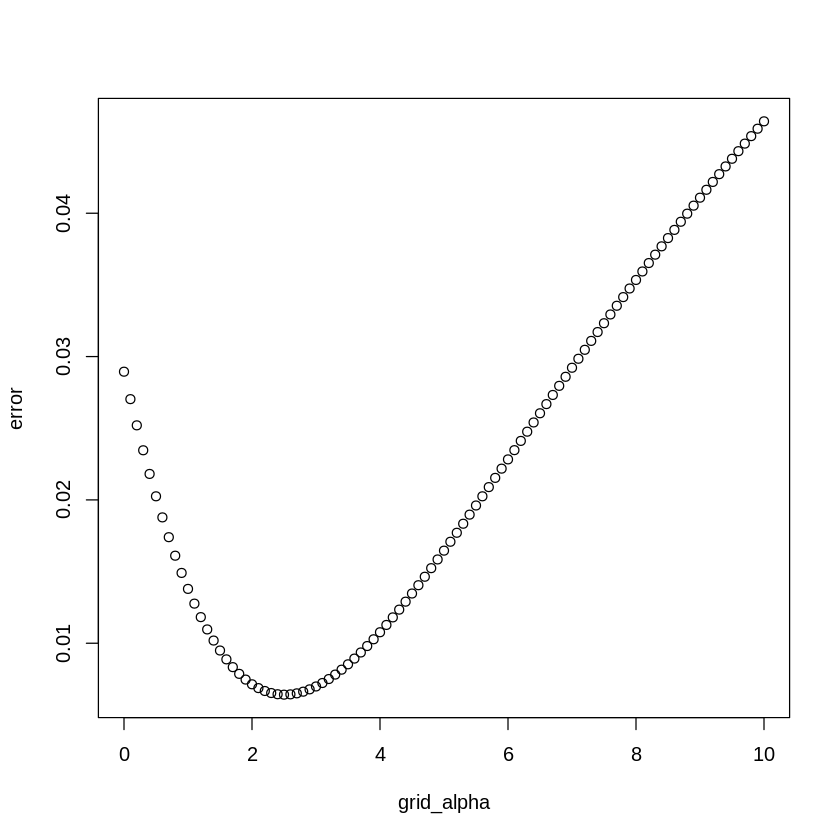

In [52]:
grid_alpha <- seq(from = 0, to = 10, by = 0.1)                                                    #
error <- rep(NA, length(grid_alpha))                                                              #

for (i in 1:length(grid_alpha)) {                                                                 #

  win_pct <- calculate_win_pct(record, grid_alpha[i])                                             #

  error[i] <- win_pct |>                                                                          #
    dplyr::summarize(error = mean((actual_win_pct - pythag_win_pct)^2)) |>                        #
    with(error)                                                                                   #
}                                                                                                 #

alpha_min <- grid_alpha[which.min(error)]                                                         #
print(alpha_min)
plot(grid_alpha, error)                                                                           #

# Part 2: Evaluating the Effectiveness

Now that we have determined the optimal value of $\alpha$ for our data, let's compare the predictive value of Pythagorean winning percentage versus the predictive value of actual winning percentage. To do this, we'll need to split our data into two halves. Because we'll be peforming the same computations on each half of data, it will help to create a function that we can call multiple times (instead of duplicating code).

EXERCISE #0

Create a function that takes in a dataframe of scores (like the one we read from a CSV at the top of this notebook) and returns a dataframe with each team's wins, losses, points scored and points allowed in each season.

In [53]:
calculate_record <- function(data) {                                                              #

  # Calculate each team's home record                                                             #
  record_home <- data |>                                                                          #
    dplyr::group_by(season, team = home_team) |>                                                  #
    dplyr::summarize(                                                                             #
      wins = sum(home_score > away_score),                                                        #
      losses = sum(home_score < away_score),                                                      #
      ties = sum(home_score == away_score),                                                       #
      points_scored = sum(home_score),                                                            #
      points_allowed = sum(away_score)                                                            #
    )                                                                                             #

  # Calculate each team's away record                                                             #
  record_away <- data |>                                                                          #
    dplyr::group_by(season, team = away_team) |>                                                  #
    dplyr::summarize(                                                                             #
      wins = sum(away_score > home_score),                                                        #
      losses = sum(away_score < home_score),                                                      #
      ties = sum(away_score == home_score),                                                       #
      points_scored = sum(away_score),                                                            #
      points_allowed = sum(home_score)                                                            #
    )                                                                                             #

  # Calculate each team's record (combining their wins and their losses)                          #
  record <- dplyr::bind_rows(record_home, record_away) |>                                         #
    dplyr::group_by(season, team) |>                                                              #
    dplyr::summarize(                                                                             #
      wins = sum(wins),                                                                           #
      losses = sum(losses),                                                                       #
      ties = sum(ties),                                                                           #
      points_scored = sum(points_scored),                                                         #
      points_allowed = sum(points_allowed)                                                        #
    )                                                                                             #

  return(record)                                                                                  #
}                                                                                                 #


EXERCISE #1

Calculate actual winning percentage and Pythagorean winning percentage for each team in the first half of each season (games up to and including Week 9) and the second half of each season (games Week 10 and beyond).

In [54]:
win_pct_1 <- data |>                                                                              #
  dplyr::filter(week <= 9) |>                                                                     #
  calculate_record() |>                                                                           #
  calculate_win_pct(alpha = alpha_min)                                                            #

win_pct_2 <- data |>                                                                              #
  dplyr::filter(week >= 10) |>                                                                    #
  calculate_record() |>                                                                           #
  calculate_win_pct(alpha = alpha_min)                                                            #

`summarise()` has grouped output by 'season'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season'. You can override using the
`.groups` argument.
Adding missing grouping variables: `season`
`summarise()` has grouped output by 'season'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season'. You can override using the
`.groups` argument.
Adding missing grouping variables: `season`


EXERCISE #2

Plot first-half actual winning percentage vs. second-half actual winning percentage. Plot first-half Pythagorean winning percentage vs. second-half Pythagorean winning percentage. Which relationship looks stronger?

To see a hint, double click **here**.
<!---
Start by creating a dataframe that has _both_ first-half and second-half winning percentages for each time. You can do this by joining the separate first-half and second-half dataframes.
--->

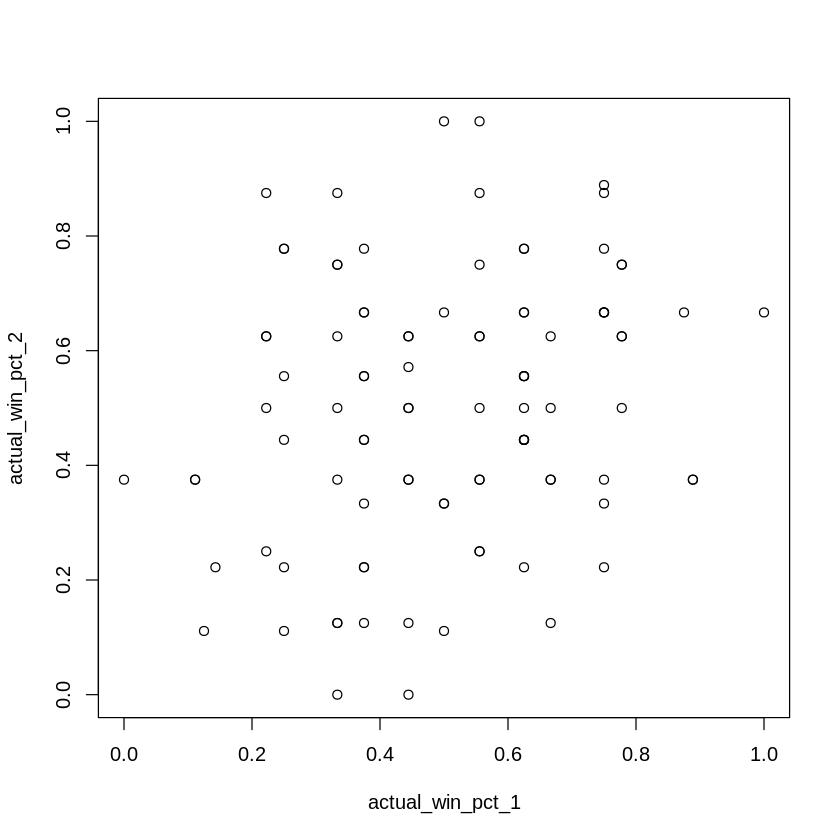

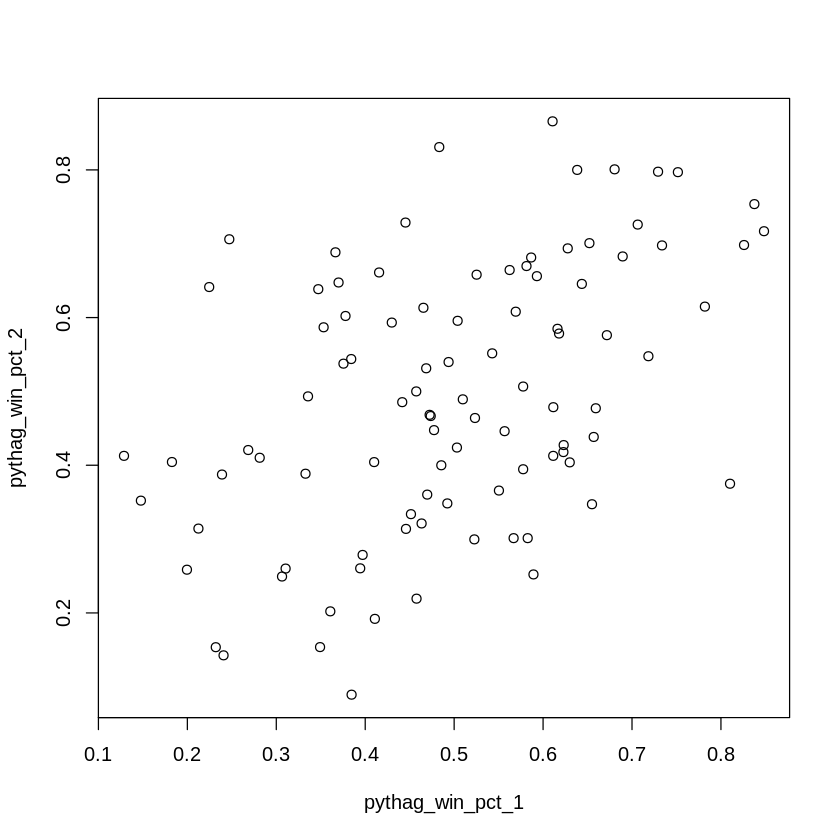

In [55]:
win_pct <- win_pct_1 |>                                                                           #
  dplyr::left_join(win_pct_2, by = c("season", "team"), suffix = c("_1", "_2"))                   #

with(win_pct, plot(actual_win_pct_1, actual_win_pct_2))                                           #
with(win_pct, plot(pythag_win_pct_1, pythag_win_pct_2))                                           #

EXERCISE #3

Calculate the following correlations:
1. 1st half actual win pct vs. 2nd half actual win pct
2. 1st half Pythag win pct vs. 2nd half Pythag win pct
3. 1st half Pythag win pct vs. 2nd half actual win pct
4. 1st half residual (actual - Pythag) win pct vs. 2nd half residual (actual - Pythag) win pct

What is your interpretation of the results?

In [56]:
with(win_pct, cor(actual_win_pct_1, actual_win_pct_2))                                            #
with(win_pct, cor(pythag_win_pct_1, pythag_win_pct_2))                                            #
with(win_pct, cor(pythag_win_pct_1, actual_win_pct_2))                                            #
with(win_pct, cor(actual_win_pct_1 - pythag_win_pct_1, actual_win_pct_2 - pythag_win_pct_2))      #

[1] 0.2241476

[1] 0.4620104

[1] 0.3841189

[1] -0.02763505

EXERCISE #4 (Challenge)

How much uncertainty is there in the estimated correlations from Exercise #3? In other words, what is the standard error on the correlations you estimated? How does this affect your qualitative interpretation of the results?